In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Utils import *
import numba as nb
from numba import njit

import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi 
from sbi import analysis as analysis



### 2. Filter the data of required conditions

In [4]:
# Load the simulated data
data = np.load('saved/SBI_Results_lr_combined.npz')
print("Data loaded")
data['theta'].shape

Data loaded


(50000, 2)

In [5]:
# If the data is loaded but not simulated
# Convert from numpy to torch
theta = torch.from_numpy(data['theta'])
x = torch.from_numpy(data['x'])

In [9]:
# Range of values of theta
u = theta.unique()
u.max(), u.min()

(tensor(0.1000), tensor(2.3842e-07))

In [4]:
# Filter for stability < 0.1
# x - S, B, D, A, mu, sigma, r_squared
# x[:,0].unique(return_counts=True)

x[:,0].unique(return_counts=True)

(tensor([0.0206, 0.0255, 0.0456,  ..., 0.4392, 0.4412, 0.4469]),
 tensor([1, 1, 1,  ..., 1, 1, 1]))

In [5]:
(x[:,0] < 0.1).sum()

tensor(369)

In [13]:
# Check range of stability values
uniq_s = x[:,0].unique()
uniq_s.max(), uniq_s.min()

(tensor(0.4469), tensor(0.0206))

In [6]:
x[idx, 5]

tensor([1.3138, 1.0761, 1.0176,  ..., 0.8698, 1.4468, 1.8533])

In [12]:
# FILTERED THE DATA FOR THE DESIRED VALUES OF LOSS

# Filter second on S
idx = x[:,0] < 0.2

theta_filtered = theta[idx]
# Only select the corresponding value of sigma
x_filtered = x[idx,5][:,None]
x_filtered.size()

torch.Size([7161, 1])

In [14]:
theta.isnan().sum()

tensor(0)

In [15]:
# Define the prior 
# number of parameters
num_dim = 2 # eta_e, eta_i

# Define priors 
prior = BoxUniform(low=0 * torch.ones(num_dim), high=0.1 * torch.ones(num_dim))


#estimator = posterior_nn(model='nsf')
# instantiate the inference object
inference = SNPE(prior=prior)
# compute the inference
# ACHTUNG! need to change theta_filtered and x_filtered
inference = inference.append_simulations(theta_filtered, x_filtered)


In [16]:
inference

In [17]:
# train the neural density estimator
density_estimator = inference.train()


 Neural network successfully converged after 207 epochs.

In [22]:
# Generate the posterior
posterior = inference.build_posterior(density_estimator)


In [23]:
posterior

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

### 3. Study posterior distribution

In [37]:
# Take an observation of a standard deviation of 0.9
observation = torch.zeros(1) + 0.01
#observation
#.set_default_x()
# generate the first observation
# theta_1 = prior.sample((1,))
# e_target = 5.0, i_target = 1.5, nonlinparams = 0, E_inputs =200 , I_inputs = 50, E_currents =, I_currents, W_dend_E, W_dend_I, dendrite_leak, tau, dt, params, time
#x_obs_1 = simulate_neuron_lr(theta_1)
# theta_1

In [38]:
posterior_samples = posterior.sample((10000,), x=observation)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

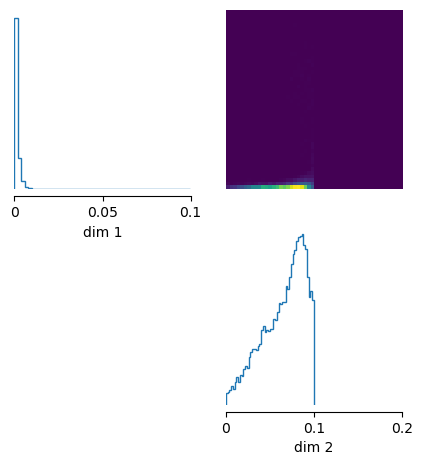

In [39]:

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[0,0.1], [0, 0.2]], figsize=(5, 5)
)

In [36]:
# inference on several rounds
"""
num_rounds = 2
posteriors = []
proposal = prior


for _ in range(num_rounds):
    #theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(observation)


"""

'\nnum_rounds = 2\nposteriors = []\nproposal = prior\n\n\nfor _ in range(num_rounds):\n    #theta, x = simulate_for_sbi(simulator, proposal, num_simulations=500)\n    density_estimator = inference.append_simulations(\n        theta, x, proposal=proposal\n    ).train()\n    posterior = inference.build_posterior(density_estimator)\n    posteriors.append(posterior)\n    proposal = posterior.set_default_x(observation)\n\n\n'

In [16]:
true_params = [0.2, 0.33]
# generate an obersevation
observation = torch.tensor([0.2, 0.33])

# Simulate with the parameters:
sum_statistics  = simulator_neuron(observation)


NameError: name 'simulator_neuron' is not defined

In [75]:
A, mu, sigma = sum_statistics[3], sum_statistics[4], sum_statistics[5]

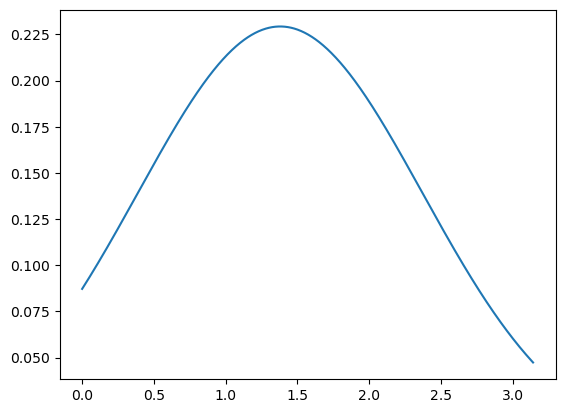

In [84]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))


x = np.linspace(0, np.pi, 1000) 
y = gaussian(x, A, mu, sigma)


plt.plot(x, y)

In [82]:
y.shape

(450,)

In [67]:
samples = posterior.sample((10000,), x=sum_statistics)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [72]:
#HBox(children=(FloatProgress(value=0.0, description='Drawing 10000 posterior samples', max=10000.0)


IndexError: string index out of range

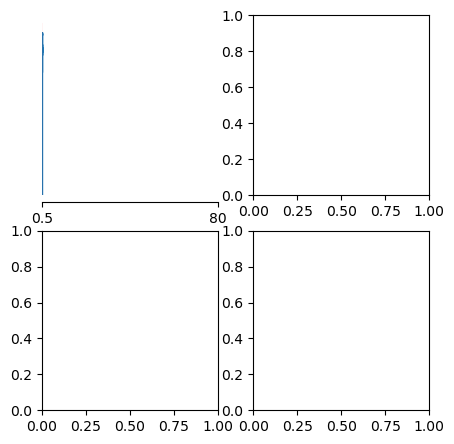

In [86]:
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.5, 80], [1e-4, 15.0]],
    ticks=[[0.5, 80], [1e-4, 15.0]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);